In [1]:
from sklearn.pipeline import Pipeline
import nbimporter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.svm import SVR

In [2]:
def build_pipeline(model):
    preprocessor = build_preprocessor()
    return Pipeline([
        ("Preprocessing", preprocessor),
        ("Model", model)
    ])

In [3]:
df = pd.read_csv("preprocessed_youtube_data.csv")

In [4]:
df = df.dropna(subset=["views"])

In [5]:
X = df.drop(columns=["views"])
y = df["views"]

In [6]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [7]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_preds = lr_model.predict(X_test)

In [8]:
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)

print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression MAE:", lr_mae)
print("Linear Regression R² Score:", lr_r2)

Linear Regression RMSE: 1554313.9409123093
Linear Regression MAE: 861530.7576271186
Linear Regression R² Score: -0.27917856319310563


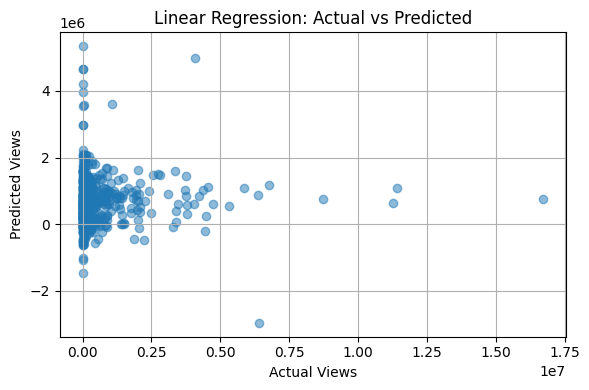

In [9]:
# Actual vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, lr_preds, alpha=0.5)
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.title("Linear Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

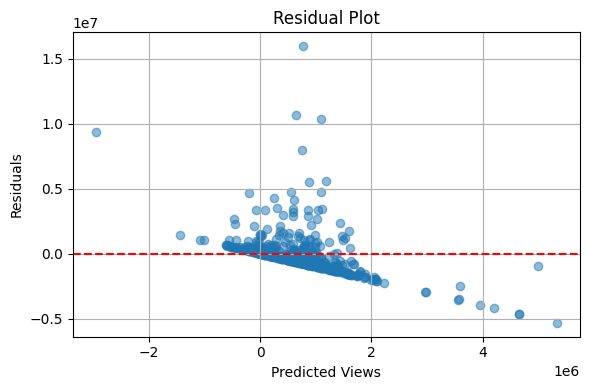

In [10]:
# Residual Plot
residuals = y_test - lr_preds
plt.figure(figsize=(6, 4))
plt.scatter(lr_preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Views")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# SVM Model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

svm_preds = svm_model.predict(X_test)

In [12]:
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_preds))
svm_mae = mean_absolute_error(y_test, svm_preds)
svm_r2 = r2_score(y_test, svm_preds)

print("SVM Regression RMSE:", svm_rmse)
print("SVM Regression MAE:", svm_mae)
print("SVM Regression R² Score:", svm_r2)

SVM Regression RMSE: 1449452.2925841373
SVM Regression MAE: 526671.9444851057
SVM Regression R² Score: -0.11240143193043539


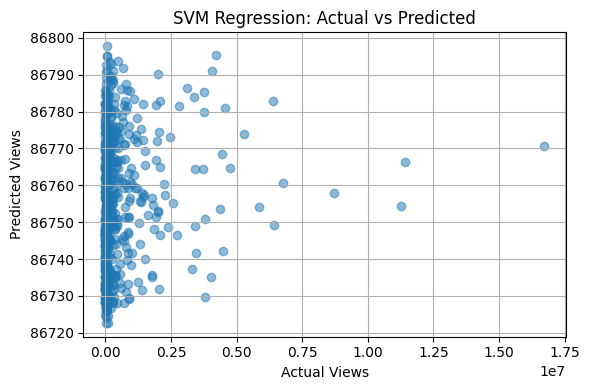

In [13]:
# Actual vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, svm_preds, alpha=0.5)
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.title("SVM Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

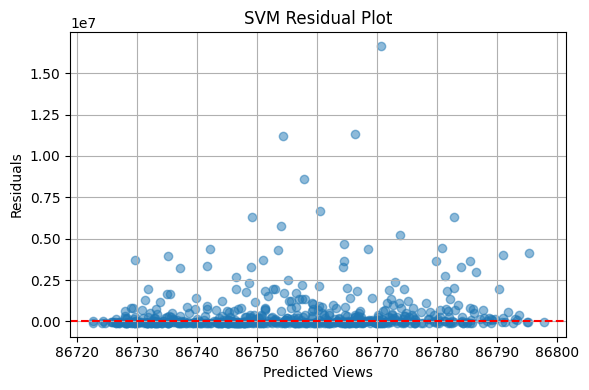

In [14]:
# Residuals
residuals_svm = y_test - svm_preds
plt.figure(figsize=(6, 4))
plt.scatter(svm_preds, residuals_svm, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Views")
plt.ylabel("Residuals")
plt.title("SVM Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()